<a href="https://colab.research.google.com/github/neuropoly/single_voxel_mrs_b0_shimming/blob/main/SVS_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SVS processing - interactive notebook

This notebook demos the process of fitting a single voxel MRS data using FSL-MRS.

## Contents:

1. [Install dependencies](#1.-Install-dependencies)
2. [Import required libraries](#2.-Import-required-libraries)
3. [Download the data](#3.-Download-the-data)
4. [B0 Fieldmaps calculation](#4.-Compute-fieldmaps)
5. [B0 shimming](#5.-Perform-B0-shimming-using-the-computed-filedmaps)
6. [B0 Fieldmaps comparison](#6.-B0-Fieldmaps-comparison)
7. [MRS analysis](#7.-MRS-analysis)


## 1. Install dependencies

In [3]:
%%capture
%cd /content
!git clone --recurse-submodules https://git.fmrib.ox.ac.uk/fsl/fsl_mrs.git
%cd /content/fsl_mrs
!pip install .

%cd /content
!git clone --single-branch --branch gradient_optimizer https://github.com/shimming-toolbox/shimming-toolbox.git
%cd /content/shimming-toolbox/
!pip install .


In [ ]:
# Restart the runtime to resolve the compatibilty issues between the packages
import os
os.kill(os.getpid(), 9)

## 2. Import required libraries

In [1]:
%%capture
%cd /content
import os
os.environ["LD_PRELOAD"] = "";
os.environ["APPTAINER_BINDPATH"] = "/content"
os.environ["MPLCONFIGDIR"] = "/content/matplotlib-mpldir"
os.environ["LMOD_CMD"] = "/usr/share/lmod/lmod/libexec/lmod"
os.environ["MODULEPATH"] = "/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/molecular_biology:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/workflows:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/visualization:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/structural_imaging:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/statistics:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/spine:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/spectroscopy:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/shape_analysis:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/segmentation:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/rodent_imaging:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/quantitative_imaging:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/quality_control:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/programming:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/phase_processing:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/machine_learning:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/image_segmentation:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/image_registration:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/image_reconstruction:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/hippocampus:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/functional_imaging:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/electrophysiology:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/diffusion_imaging:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/data_organisation:/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/body"

!curl -J -O https://raw.githubusercontent.com/NeuroDesk/neurocommand/main/googlecolab_setup.sh
!chmod +x googlecolab_setup.sh
!./googlecolab_setup.sh


In [2]:
import lmod
await lmod.load('fsl/6.0.4')
await lmod.list()

['fsl/6.0.4']

In [3]:
import zipfile
import json
import os
import pathlib
import shutil
import datetime
import numpy as np
import nibabel as nib
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import HTML
import fsl_mrs.utils.mrs_io as mrs_io
from fsl_mrs.utils.preproc import nifti_mrs_proc as proc
import fsl_mrs as mrs
from fsl_mrs.utils import report, fitting, misc, plotting
from shimmingtoolbox.prepare_fieldmap import prepare_fieldmap
from shimmingtoolbox.load_nifti import read_nii
from shimmingtoolbox.cli import b0shim
from shimmingtoolbox.masking.threshold import threshold as mask_threshold

try:
    import nilearn
    import seaborn as sns
    import plotly.graph_objects as go
    import plotly.io as pio

except ImportError:
    !pip install seaborn
    import seaborn as sns
    !pip install nilearn
    import nilearn
    !pip install plotly
    import plotly.graph_objects as go
    import plotly.io as pio

!pip install osfclient

print('Necessary libraries are imported')


Necessary libraries are imported


## 3. Download the data

In [4]:
!osf -u behrouz.vejdani-afkham@polymtl.ca -p s3gwv fetch /SVS_MRS_DATA.zip

Please input your password: 
100% 348M/348M [00:03<00:00, 107Mbytes/s]


In [5]:
# Unzip the data
zipped_data = "/content/" + "SVS_MRS_DATA.zip"
with zipfile.ZipFile(zipped_data,"r") as zipfile:
  zipfile.extractall('/content/')

## 4. Compute fieldmaps

In [6]:
if os.path.basename(os.getcwd()) != 'SVS_MRS_DATA':
    os.chdir(os.getcwd()+'/SVS_MRS_DATA/')

current_path = os.getcwd()
print(current_path)
shim_methods=['siemens','pi' ,'quadprog' ,'lsq','grad']
subjects_list = [name for name in os.listdir() if os.path.isdir(name) and name.startswith('sub')]
subjects_list.sort(key=lambda x: int(x.split('-')[1]))
print(subjects_list)

# Iterate over each subject
for subject in subjects_list:
    derivative_path = current_path + f"/derivatives/{subject}/"
    fmap_path = f"{derivative_path}fmap/"
    if not os.path.exists(fmap_path):
        os.makedirs(fmap_path)

    mask_mrs_nii = nib.load(derivative_path + 'mask_mrs.nii.gz')
    mask_mrs = mask_mrs_nii.get_fdata()
    mask_anat_nii = nib.load (derivative_path + 'bet_anat_mask.nii.gz')

    # Iterate over each shim method
    for method in shim_methods:

        # Load the file corresponding to the method
        gre_path =  current_path + f"/{subject}/fmap/"
        mag = read_nii(gre_path + f"{subject}_acq-{method}Shim_magnitude1.nii.gz")
        phase1 = read_nii(gre_path + f"{subject}_acq-{method}Shim_phase1.nii.gz", auto_scale=True)
        phase2 = read_nii(gre_path + f"{subject}_acq-{method}Shim_phase2.nii.gz", auto_scale=True)

        # Load JSON data from the magnitude nifti
        with open(gre_path + f"{subject}_acq-{method}Shim_magnitude1.json", 'r') as mag_json:
            json_data = json.load(mag_json)

        phase_list_data = [phase1[2], phase2[2]]

        # scale the phase data to (-pi, pi) range
        scaled_phase_list_data = [((phase_list_data[i] - np.min(phase_list_data[i]))/(np.max(phase_list_data[i])-np.min(phase_list_data[i])))
                             *2*np.pi-np.pi for i in range(len(phase_list_data))]
        # convert to nifti
        scaled_phase_list_nii = [nib.Nifti1Image(scaled_phase_list_data[i], phase1[0].affine, phase1[0].header)
                             for i in range(len(scaled_phase_list_data))]

        EchoTime1 = phase1[1]['EchoTime']
        EchoTime2 = phase2[1]['EchoTime']
        echo_times = [EchoTime1, EchoTime2]

        # compute fieldmap for each method
        fieldmap = prepare_fieldmap(scaled_phase_list_nii, echo_times, mag[2], unwrapper='prelude', gaussian_filter= True, nii_mask= mask_anat_nii, sigma=0.5)
        # store the fieldmap under the corresponding path
        fieldmap_nii = nib.Nifti1Image(fieldmap[0], phase1[0].affine, phase1[0].header )
        nib.save(fieldmap_nii, fmap_path + f"{subject}_acq-{method}-fieldmap.nii.gz")

        # store the corresponding json file for each fieldmap
        with open(fmap_path + f"{subject}_acq-{method}-fieldmap.json", 'w') as fmap_json:
            json.dump(json_data, fmap_json)


/content/SVS_MRS_DATA
['sub-1', 'sub-2', 'sub-3', 'sub-4', 'sub-5']


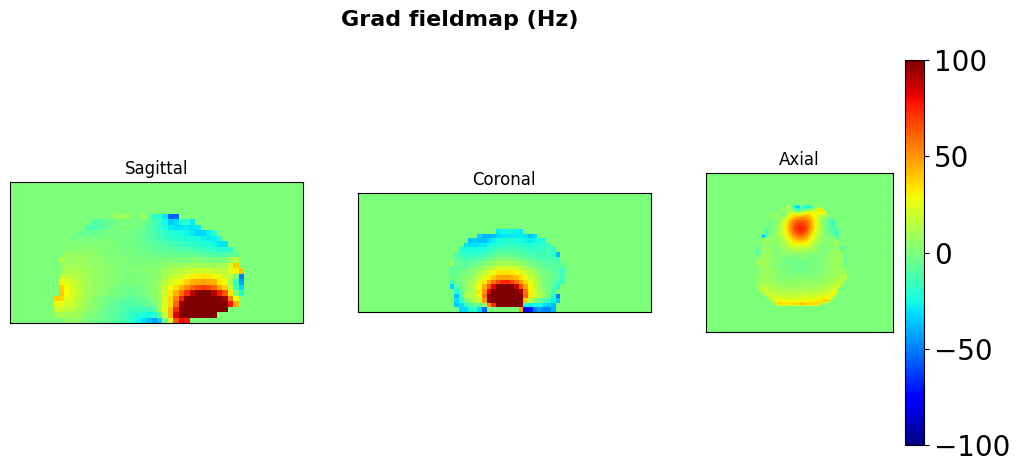

In [ ]:
import matplotlib.gridspec as gridspec
# Create a figure with a specific size and white background
fig = plt.figure(figsize=(12, 5), facecolor='white')
plt.suptitle('Grad fieldmap (Hz)', fontsize=16, fontweight='bold')
# Define gridspec
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 0.8])

# Plot sagittal cut
ax1 = plt.subplot(gs[0])
ax1.imshow(np.rot90(fieldmap[0][30,:,:]), vmin=-100, vmax=100, cmap='jet')
ax1.set_xticks([])  # Turn off x-axis ticks
ax1.set_yticks([])  # Turn off y-axis ticks
ax1.set_title('Sagittal', fontsize=12)

# Plot coronal cut
ax2 = plt.subplot(gs[1])
ax2.imshow(np.rot90(fieldmap[0][:,34,:]), vmin=-100, vmax=100,  cmap='jet')
ax2.set_xticks([])  # Turn off x-axis ticks
ax2.set_yticks([])  # Turn off y-axis ticks
ax2.set_title('Coronal', fontsize=12)

# Plot axial cut
ax3 = plt.subplot(gs[2])
img = ax3.imshow(np.rot90(fieldmap[0][...,6]), vmin=-100, vmax=100,  cmap='jet')
ax3.set_xticks([])  # Turn off x-axis ticks
ax3.set_yticks([])  # Turn off y-axis ticks
ax3.set_title('Axial', fontsize=12)
cbar = plt.colorbar(img, ax=ax3)  # Add color bar
cbar.ax.tick_params(labelsize=20)  # Set font size for color bar

# Save the figure with 300 dpi
plt.savefig('fieldmap_example.png', dpi=300)
plt.show()

## 5. Perform B0 shimming using the computed filedmaps

In [ ]:
%%bash

# Generate subjects list as an array
subjects_list=$(find .  -type d -maxdepth 1 -name "sub-*"| sort -V)
IFS=$'\n' read -d '' -r -a subjects_array <<< "$subjects_list"
echo "subjects list are: $subjects_list"

path_derivatives=$(find . -type d -name derivatives)
shim_methods=("pi" "quadprog" "lsq" "grad")
for subject in "${subjects_array[@]}"; do
    echo "Subject: $subject"
    subject_name=$(basename "$subject")
    fmap_path=${path_derivatives}/${subject_name}
    mask=$(find ${fmap_path} -type f -name "mask_mrs.nii.gz")
    echo $mask
    output_grad="${fmap_path}/fmap/static_shim_grad"
    output_lsq="${fmap_path}/fmap/static_shim_lsq"
    output_pi="${fmap_path}/fmap/static_shim_pi"
    output_quadprog="${fmap_path}/fmap/static_shim_quadprog"

    for method in "${shim_methods[@]}"; do

        fieldmap=$(find ${path_derivatives}/${subject_name}/fmap -type f -name "${subject_name}_acq-${method}-fieldmap.nii.gz")
        echo $fieldmap
        if [ "${method}" = "lsq" ]; then
            st_b0shim dynamic --fmap "${fieldmap}" --anat "${fieldmap}" --mask "${mask}" --mask-dilation-kernel-size "5" --optimizer-criteria "mse" --optimizer-method "least_squares" --slices "volume" --output-file-format-scanner "chronological-coil" --scanner-coil-order "0,1,2" --output-value-format "absolute" --output "${output_lsq}"  || exit

        elif [ "${method}" = "grad" ]; then
            st_b0shim dynamic --fmap "${fieldmap}" --anat "${fieldmap}" --mask "${mask}" --mask-dilation-kernel-size "5" --optimizer-criteria "ps_huber" --optimizer-method "gradient" --slices "volume" --output-file-format-scanner "chronological-coil" --scanner-coil-order "0,1,2" --output-value-format "absolute" --output "${output_grad}" || exit

        elif [ "${method}" = "pi" ]; then
            st_b0shim dynamic --fmap "${fieldmap}" --anat "${fieldmap}" --mask "${mask}" --mask-dilation-kernel-size "5" --optimizer-method "pseudo_inverse" --slices "volume" --output-file-format-scanner "chronological-coil" --scanner-coil-order "0,1,2" --output-value-format "absolute" --output "${output_pi}"  || exit

        elif [ "${method}" = "quadprog" ]; then
            st_b0shim dynamic --fmap "${fieldmap}" --anat "${fieldmap}" --mask "${mask}" --mask-dilation-kernel-size "5" --optimizer-method "quad_prog" --slices "volume" --output-file-format-scanner "chronological-coil" --scanner-coil-order "0,1,2" --output-value-format "absolute" --output "${output_quadprog}"  || exit

        fi
    done
done


subjects list are: ./sub-1
./sub-2
./sub-3
./sub-4
./sub-5
Subject: ./sub-1
./derivatives/sub-1/mask_mrs.nii.gz
./derivatives/sub-1/fmap/sub-1_acq-PI-fieldmap.nii.gz


INFO:shimmingtoolbox.cli.b0shim:The slices to shim are:
[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25)]
INFO:shimmingtoolbox.cli.b0shim:Coil txt file(s) are here:
/Users/behrouz/SYNGO_TRANSFER/previous_data/SVS_MRS_DATA/derivatives/sub-1/fmap/static_shim_PI/coefs_coil0_Prisma_fit.txt
INFO:shimmingtoolbox.cli.b0shim:Plotting figure(s)
INFO:shimmingtoolbox.cli.b0shim: Plotting currents
INFO:shimmingtoolbox.cli.b0shim:Finished plotting figure(s)


./derivatives/sub-1/fmap/sub-1_acq-QuadProg-fieldmap.nii.gz


INFO:shimmingtoolbox.cli.b0shim:The slices to shim are:
[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25)]
INFO:shimmingtoolbox.cli.b0shim:Coil txt file(s) are here:
/Users/behrouz/SYNGO_TRANSFER/previous_data/SVS_MRS_DATA/derivatives/sub-1/fmap/static_shim_QuadProg/coefs_coil0_Prisma_fit.txt
INFO:shimmingtoolbox.cli.b0shim:Plotting figure(s)
INFO:shimmingtoolbox.cli.b0shim: Plotting currents
INFO:shimmingtoolbox.cli.b0shim:Finished plotting figure(s)


./derivatives/sub-1/fmap/sub-1_acq-LSq-fieldmap.nii.gz


INFO:shimmingtoolbox.cli.b0shim:The slices to shim are:
[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25)]
INFO:shimmingtoolbox.cli.b0shim:Coil txt file(s) are here:
/Users/behrouz/SYNGO_TRANSFER/previous_data/SVS_MRS_DATA/derivatives/sub-1/fmap/static_shim_LSq/coefs_coil0_Prisma_fit.txt
INFO:shimmingtoolbox.cli.b0shim:Plotting figure(s)
INFO:shimmingtoolbox.cli.b0shim: Plotting currents
INFO:shimmingtoolbox.cli.b0shim:Finished plotting figure(s)


./derivatives/sub-1/fmap/sub-1_acq-Grad-fieldmap.nii.gz


INFO:shimmingtoolbox.cli.b0shim:The slices to shim are:
[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25)]
INFO:shimmingtoolbox.cli.b0shim:Coil txt file(s) are here:
/Users/behrouz/SYNGO_TRANSFER/previous_data/SVS_MRS_DATA/derivatives/sub-1/fmap/static_shim_Grad/coefs_coil0_Prisma_fit.txt
INFO:shimmingtoolbox.cli.b0shim:Plotting figure(s)
INFO:shimmingtoolbox.cli.b0shim: Plotting currents
INFO:shimmingtoolbox.cli.b0shim:Finished plotting figure(s)


Subject: ./sub-2
./derivatives/sub-2/mask_mrs.nii.gz
./derivatives/sub-2/fmap/sub-2_acq-PI-fieldmap.nii.gz


INFO:shimmingtoolbox.cli.b0shim:The slices to shim are:
[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25)]
INFO:shimmingtoolbox.cli.b0shim:Coil txt file(s) are here:
/Users/behrouz/SYNGO_TRANSFER/previous_data/SVS_MRS_DATA/derivatives/sub-2/fmap/static_shim_PI/coefs_coil0_Prisma_fit.txt
INFO:shimmingtoolbox.cli.b0shim:Plotting figure(s)
INFO:shimmingtoolbox.cli.b0shim: Plotting currents
INFO:shimmingtoolbox.cli.b0shim:Finished plotting figure(s)


./derivatives/sub-2/fmap/sub-2_acq-QuadProg-fieldmap.nii.gz


INFO:shimmingtoolbox.cli.b0shim:The slices to shim are:
[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25)]
INFO:shimmingtoolbox.cli.b0shim:Coil txt file(s) are here:
/Users/behrouz/SYNGO_TRANSFER/previous_data/SVS_MRS_DATA/derivatives/sub-2/fmap/static_shim_QuadProg/coefs_coil0_Prisma_fit.txt
INFO:shimmingtoolbox.cli.b0shim:Plotting figure(s)
INFO:shimmingtoolbox.cli.b0shim: Plotting currents
INFO:shimmingtoolbox.cli.b0shim:Finished plotting figure(s)


./derivatives/sub-2/fmap/sub-2_acq-LSq-fieldmap.nii.gz


INFO:shimmingtoolbox.cli.b0shim:The slices to shim are:
[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25)]
INFO:shimmingtoolbox.cli.b0shim:Coil txt file(s) are here:
/Users/behrouz/SYNGO_TRANSFER/previous_data/SVS_MRS_DATA/derivatives/sub-2/fmap/static_shim_LSq/coefs_coil0_Prisma_fit.txt
INFO:shimmingtoolbox.cli.b0shim:Plotting figure(s)
INFO:shimmingtoolbox.cli.b0shim: Plotting currents
INFO:shimmingtoolbox.cli.b0shim:Finished plotting figure(s)


./derivatives/sub-2/fmap/sub-2_acq-Grad-fieldmap.nii.gz


INFO:shimmingtoolbox.cli.b0shim:The slices to shim are:
[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25)]
INFO:shimmingtoolbox.cli.b0shim:Coil txt file(s) are here:
/Users/behrouz/SYNGO_TRANSFER/previous_data/SVS_MRS_DATA/derivatives/sub-2/fmap/static_shim_Grad/coefs_coil0_Prisma_fit.txt
INFO:shimmingtoolbox.cli.b0shim:Plotting figure(s)
INFO:shimmingtoolbox.cli.b0shim: Plotting currents
INFO:shimmingtoolbox.cli.b0shim:Finished plotting figure(s)


Subject: ./sub-3
./derivatives/sub-3/mask_mrs.nii.gz
./derivatives/sub-3/fmap/sub-3_acq-PI-fieldmap.nii.gz


INFO:shimmingtoolbox.cli.b0shim:The slices to shim are:
[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25)]
INFO:shimmingtoolbox.cli.b0shim:Coil txt file(s) are here:
/Users/behrouz/SYNGO_TRANSFER/previous_data/SVS_MRS_DATA/derivatives/sub-3/fmap/static_shim_PI/coefs_coil0_Prisma_fit.txt
INFO:shimmingtoolbox.cli.b0shim:Plotting figure(s)
INFO:shimmingtoolbox.cli.b0shim: Plotting currents
INFO:shimmingtoolbox.cli.b0shim:Finished plotting figure(s)


./derivatives/sub-3/fmap/sub-3_acq-QuadProg-fieldmap.nii.gz


INFO:shimmingtoolbox.cli.b0shim:The slices to shim are:
[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25)]
INFO:shimmingtoolbox.cli.b0shim:Coil txt file(s) are here:
/Users/behrouz/SYNGO_TRANSFER/previous_data/SVS_MRS_DATA/derivatives/sub-3/fmap/static_shim_QuadProg/coefs_coil0_Prisma_fit.txt
INFO:shimmingtoolbox.cli.b0shim:Plotting figure(s)
INFO:shimmingtoolbox.cli.b0shim: Plotting currents
INFO:shimmingtoolbox.cli.b0shim:Finished plotting figure(s)


./derivatives/sub-3/fmap/sub-3_acq-LSq-fieldmap.nii.gz


INFO:shimmingtoolbox.cli.b0shim:The slices to shim are:
[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25)]
INFO:shimmingtoolbox.cli.b0shim:Coil txt file(s) are here:
/Users/behrouz/SYNGO_TRANSFER/previous_data/SVS_MRS_DATA/derivatives/sub-3/fmap/static_shim_LSq/coefs_coil0_Prisma_fit.txt
INFO:shimmingtoolbox.cli.b0shim:Plotting figure(s)
 i_shim: 0
INFO:shimmingtoolbox.cli.b0shim: Plotting currents
INFO:shimmingtoolbox.cli.b0shim:Finished plotting figure(s)


./derivatives/sub-3/fmap/sub-3_acq-Grad-fieldmap.nii.gz


INFO:shimmingtoolbox.cli.b0shim:The slices to shim are:
[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25)]
INFO:shimmingtoolbox.cli.b0shim:Coil txt file(s) are here:
/Users/behrouz/SYNGO_TRANSFER/previous_data/SVS_MRS_DATA/derivatives/sub-3/fmap/static_shim_Grad/coefs_coil0_Prisma_fit.txt
INFO:shimmingtoolbox.cli.b0shim:Plotting figure(s)
INFO:shimmingtoolbox.cli.b0shim: Plotting currents
INFO:shimmingtoolbox.cli.b0shim:Finished plotting figure(s)


Subject: ./sub-4
./derivatives/sub-4/mask_mrs.nii.gz
./derivatives/sub-4/fmap/sub-4_acq-PI-fieldmap.nii.gz


INFO:shimmingtoolbox.cli.b0shim:The slices to shim are:
[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25)]
INFO:shimmingtoolbox.cli.b0shim:Coil txt file(s) are here:
/Users/behrouz/SYNGO_TRANSFER/previous_data/SVS_MRS_DATA/derivatives/sub-4/fmap/static_shim_PI/coefs_coil0_Prisma_fit.txt
INFO:shimmingtoolbox.cli.b0shim:Plotting figure(s)
INFO:shimmingtoolbox.cli.b0shim: Plotting currents
INFO:shimmingtoolbox.cli.b0shim:Finished plotting figure(s)


./derivatives/sub-4/fmap/sub-4_acq-QuadProg-fieldmap.nii.gz


INFO:shimmingtoolbox.cli.b0shim:The slices to shim are:
[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25)]
INFO:shimmingtoolbox.cli.b0shim:Coil txt file(s) are here:
/Users/behrouz/SYNGO_TRANSFER/previous_data/SVS_MRS_DATA/derivatives/sub-4/fmap/static_shim_QuadProg/coefs_coil0_Prisma_fit.txt
INFO:shimmingtoolbox.cli.b0shim:Plotting figure(s)
INFO:shimmingtoolbox.cli.b0shim: Plotting currents
INFO:shimmingtoolbox.cli.b0shim:Finished plotting figure(s)


./derivatives/sub-4/fmap/sub-4_acq-LSq-fieldmap.nii.gz


INFO:shimmingtoolbox.cli.b0shim:The slices to shim are:
[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25)]
INFO:shimmingtoolbox.cli.b0shim:Coil txt file(s) are here:
/Users/behrouz/SYNGO_TRANSFER/previous_data/SVS_MRS_DATA/derivatives/sub-4/fmap/static_shim_LSq/coefs_coil0_Prisma_fit.txt
INFO:shimmingtoolbox.cli.b0shim:Plotting figure(s)
INFO:shimmingtoolbox.cli.b0shim: Plotting currents
INFO:shimmingtoolbox.cli.b0shim:Finished plotting figure(s)


./derivatives/sub-4/fmap/sub-4_acq-Grad-fieldmap.nii.gz


INFO:shimmingtoolbox.cli.b0shim:The slices to shim are:
[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25)]
INFO:shimmingtoolbox.cli.b0shim:Coil txt file(s) are here:
/Users/behrouz/SYNGO_TRANSFER/previous_data/SVS_MRS_DATA/derivatives/sub-4/fmap/static_shim_Grad/coefs_coil0_Prisma_fit.txt
INFO:shimmingtoolbox.cli.b0shim:Plotting figure(s)
INFO:shimmingtoolbox.cli.b0shim: Plotting currents
INFO:shimmingtoolbox.cli.b0shim:Finished plotting figure(s)


Subject: ./sub-5
./derivatives/sub-5/mask_mrs.nii.gz
./derivatives/sub-5/fmap/sub-5_acq-PI-fieldmap.nii.gz


INFO:shimmingtoolbox.cli.b0shim:The slices to shim are:
[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25)]
INFO:shimmingtoolbox.cli.b0shim:Coil txt file(s) are here:
/Users/behrouz/SYNGO_TRANSFER/previous_data/SVS_MRS_DATA/derivatives/sub-5/fmap/static_shim_PI/coefs_coil0_Prisma_fit.txt
INFO:shimmingtoolbox.cli.b0shim:Plotting figure(s)
INFO:shimmingtoolbox.cli.b0shim: Plotting currents
INFO:shimmingtoolbox.cli.b0shim:Finished plotting figure(s)


./derivatives/sub-5/fmap/sub-5_acq-QuadProg-fieldmap.nii.gz


INFO:shimmingtoolbox.cli.b0shim:The slices to shim are:
[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25)]
INFO:shimmingtoolbox.cli.b0shim:Coil txt file(s) are here:
/Users/behrouz/SYNGO_TRANSFER/previous_data/SVS_MRS_DATA/derivatives/sub-5/fmap/static_shim_QuadProg/coefs_coil0_Prisma_fit.txt
INFO:shimmingtoolbox.cli.b0shim:Plotting figure(s)
INFO:shimmingtoolbox.cli.b0shim: Plotting currents
INFO:shimmingtoolbox.cli.b0shim:Finished plotting figure(s)


./derivatives/sub-5/fmap/sub-5_acq-LSq-fieldmap.nii.gz


INFO:shimmingtoolbox.cli.b0shim:The slices to shim are:
[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25)]
INFO:shimmingtoolbox.cli.b0shim:Coil txt file(s) are here:
/Users/behrouz/SYNGO_TRANSFER/previous_data/SVS_MRS_DATA/derivatives/sub-5/fmap/static_shim_LSq/coefs_coil0_Prisma_fit.txt
INFO:shimmingtoolbox.cli.b0shim:Plotting figure(s)
INFO:shimmingtoolbox.cli.b0shim: Plotting currents
INFO:shimmingtoolbox.cli.b0shim:Finished plotting figure(s)


./derivatives/sub-5/fmap/sub-5_acq-Grad-fieldmap.nii.gz


INFO:shimmingtoolbox.cli.b0shim:The slices to shim are:
[(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25)]
INFO:shimmingtoolbox.cli.b0shim:Coil txt file(s) are here:
/Users/behrouz/SYNGO_TRANSFER/previous_data/SVS_MRS_DATA/derivatives/sub-5/fmap/static_shim_Grad/coefs_coil0_Prisma_fit.txt
INFO:shimmingtoolbox.cli.b0shim:Plotting figure(s)
INFO:shimmingtoolbox.cli.b0shim: Plotting currents
INFO:shimmingtoolbox.cli.b0shim:Finished plotting figure(s)


## 6. B0 Fieldmaps comparison

### 6.1 Function to analyze the fieldmaps

In [ ]:
def analyse_fieldmap(source_dir, labels, fieldmaps, output, mask, subject):
    """
    Description: Generates a violin plot representing the distribution of the given fieldmaps
    labels: List of strings including fieldmaps label
    fieldmaps: List of numpy arrays of fieldmaps in the same order as labels
    output: Output folder to save the violin plot
    mask: Numpy array of a Mask corresponding to the MRS voxel volume
    """
    sns.set(font_scale=2)

    output_path = os.path.join(source_dir, output)
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    if np.shape(mask)==np.shape(fieldmaps[0]):
        dict_map_avg = {label: fieldmap[mask == 1] for label, fieldmap in zip(labels, fieldmaps)}
    else:
        dict_map_avg = {label: fieldmap for label, fieldmap in zip(labels, fieldmaps)}

    def calculate_rmse(data):
        mean = np.mean(data)
        mse = np.mean(np.square(data - mean))
        return np.round(np.sqrt(mse), 1)

    dict_means = {key: np.round(np.mean(value), 1) for key, value in dict_map_avg.items()}
    dict_stds = {key: np.round(np.std(value), 1) for key, value in dict_map_avg.items()}
    dict_rmse = {key: calculate_rmse(value) for key, value in dict_map_avg.items()}

    ax = sns.violinplot(data=list(dict_map_avg.values()))

    for i, (key, mean) in enumerate(dict_means.items()):
        mean_str = "{:.1f}".format(mean)
        std_str = "{:.1f}".format(dict_stds[key])
        rmse_str = "{:.1f}".format(dict_rmse[key])
        ax.text(i + 0.05, mean, f"Mean: {mean_str}\nStd: {std_str}\nRMSE: {rmse_str}",
                horizontalalignment='left', fontsize=45 / len(dict_means))

    ax.set_ylabel('Frequency [Hz]', fontsize=50 / len(dict_means), fontweight='bold')
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(labels, fontsize=50 / len(dict_means), fontweight='bold')
    ax.set_title(f"{subject}: $\Delta$B0 distribution within MRS voxel", fontsize=10, fontweight='bold')

    ax.tick_params(axis='y', labelsize=10)  # Adjust the labelsize as per your preference
    plt.savefig(os.path.join(output_path, f"{subject}_B0_distribution.png"), dpi=300)
    plt.show()

    return dict_stds


### 6.2 Display the fieldmaps distribution

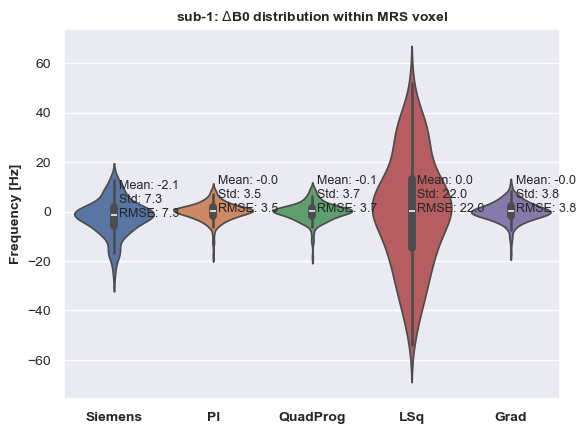

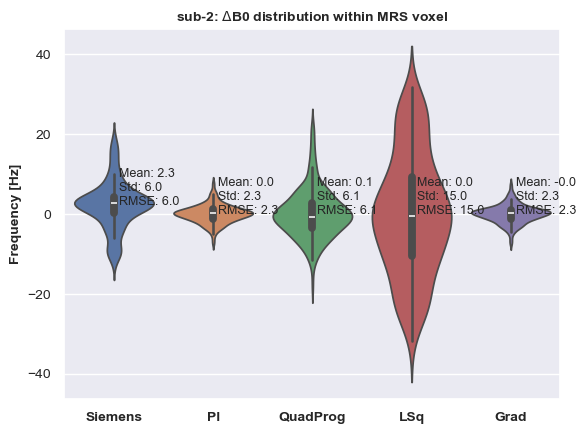

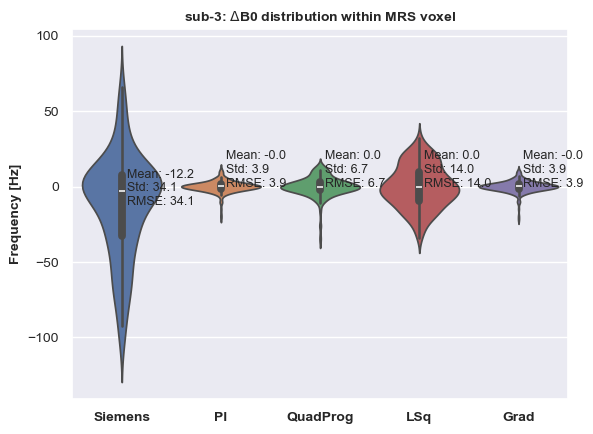

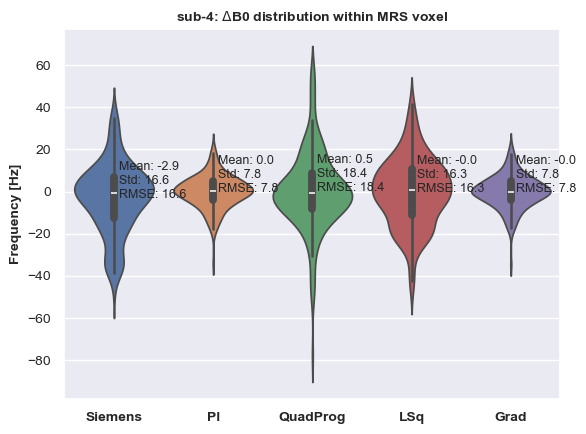

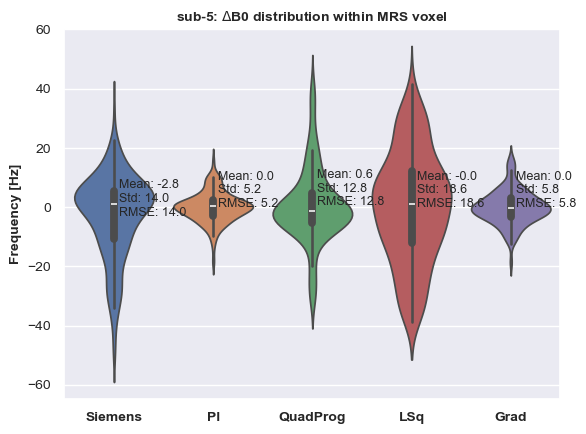

In [ ]:

all_Siemens_fmaps=[]
all_Grad_fmaps=[]
all_PI_fmaps=[]
all_LSq_fmaps=[]
all_QuadProg_fmaps=[]
sd_field_maps = {}
# Iterate over each subject
for subject in subjects_list:
    sd_field_maps[subject] = {}
    derivative_path = current_path + f"/derivatives/{subject}/"
    mask_mrs_nii = nib.load(derivative_path + 'mask_mrs.nii.gz')
    mask_mrs = mask_mrs_nii.get_fdata()

    fieldmap_Grad = nib.load (derivative_path + f"fmap/static_shim_grad/fieldmap_calculated_shim.nii.gz").get_fdata()
    fieldmap_PI = nib.load (derivative_path + f"fmap/static_shim_pi/fieldmap_calculated_shim.nii.gz").get_fdata()
    fieldmap_LSq= nib.load (derivative_path + f"fmap/static_shim_lsq/fieldmap_calculated_shim.nii.gz").get_fdata()
    fieldmap_QuadProg = nib.load (derivative_path + f"fmap/static_shim_quadprog/fieldmap_calculated_shim.nii.gz").get_fdata()
    fieldmap_Siemens = nib.load (derivative_path + f"fmap/{subject}_acq-siemens-fieldmap.nii.gz").get_fdata()

    all_Siemens_fmaps.append(fieldmap_Siemens[mask_mrs==1].flatten())
    all_Grad_fmaps.append(fieldmap_Grad[mask_mrs==1].flatten())
    all_PI_fmaps.append(fieldmap_PI[mask_mrs==1].flatten())
    all_LSq_fmaps.append(fieldmap_LSq[mask_mrs==1].flatten())
    all_QuadProg_fmaps.append(fieldmap_QuadProg[mask_mrs==1].flatten())


    fmaps = [fieldmap_Siemens, fieldmap_PI, fieldmap_QuadProg, fieldmap_LSq, fieldmap_Grad]
    labels = ["Siemens", "PI", "QuadProg", "LSq", "Grad"]
    source_dir = os.getcwd()
    output = derivative_path
    sd = analyse_fieldmap(source_dir, labels, fmaps, output, mask_mrs, subject)
    sd_field_maps[subject] =sd


In [ ]:
# Calculate standard deviation for each method across all subjects
std_dict = {}
for key in sd_field_maps['sub-1'].keys():
    values = [sd_field_maps[sub][key] for sub in sd_field_maps]
    std_dict[key] = np.round(np.std(values),1)

print("Standard Deviation for Each method across all subjects:")
for key, value in std_dict.items():
    print(f"{key}: {value} Hz")

Standard Deviation for Each method across all subjects:
Siemens: 10.1 Hz
PI: 1.9 Hz
QuadProg: 5.4 Hz
LSq: 2.9 Hz
Grad: 1.9 Hz


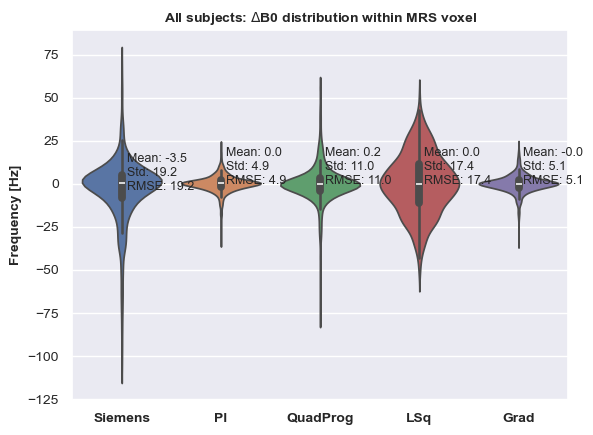

In [ ]:
shim_methods=["Siemens", "PI", "QuadProg", "LSq", "Grad"]
for method in shim_methods:
    # Create the variable name dynamically
    var_name = f"all_{method}_data"

    # Extract the data for the current method
    data = locals()[f"all_{method}_fmaps"]
    concat_data = np.concatenate(data)

    # Assign the concat_data to the dynamically created variable
    exec(f"{var_name} = concat_data")

fmaps = [all_Siemens_data, all_PI_data, all_QuadProg_data, all_LSq_data, all_Grad_data]
labels = shim_methods
source_dir = os.getcwd()
output = 'derivatives/All_subjects'
subject = 'All subjects'
distribution = analyse_fieldmap(source_dir, labels, fmaps, output, mask_mrs, subject)


### 6.3 Perform statistical test on fieldmaps

By comparing the variance, the following cell assesses whether the distribution of each shimming method significantly differs from the Siemens shimming.
The documentation for the following tests can be found [here](https://docs.scipy.org/doc/scipy-1.11.4/reference/generated/scipy.stats.shapiro.html) and [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html).


In [ ]:
# Shapiro-Wilk test to check the normality of the reference distribution (Siemens shimming)
statistic, p_value = stats.shapiro(all_Siemens_data)

# Set significant level
alpha = 0.01


# Interpret the results
if p_value < alpha:
    print('Reject the null hypothesis. The provided data does not follow a normal distribution.')
else:
    print("Fail to reject the null hypothesis. The provided data may follow a normal distribution.")

comparison_methods= ['Grad', 'PI', 'LSq', 'QuadProg']
# levene test
for method in comparison_methods:
    data = eval(f"all_{method}_data")
    statistic, p_value = stats.levene(all_Siemens_data, data)

    if p_value < 0.0001:
        print(f"Reject the null hypothesis. The variance between the Siemens and {method} groups are significantly different.")
    else:
        print(f"Fail to reject the null hypothesis. There is no significant difference in variances between the Siemens and {method} groups.")



Reject the null hypothesis. The provided data does not follow a normal distribution.
Reject the null hypothesis. The variance between the Siemens and Grad groups are significantly different.
Reject the null hypothesis. The variance between the Siemens and PI groups are significantly different.
Fail to reject the null hypothesis. There is no significant difference in variances between the Siemens and LSq groups.
Reject the null hypothesis. The variance between the Siemens and QuadProg groups are significantly different.


In [ ]:
# Comparing pi and quadprog to the grad method

comparison_methods= ['PI', 'QuadProg']
# levene test
for method in comparison_methods:
    data = eval(f"all_{method}_data")
    statistic, p_value = stats.levene(all_Grad_data, data)

    # Set significancy level
    alpha = 0.01

    # Interpret the results
    if p_value < alpha:
        print(f"Reject the null hypothesis. The variance between the gradient and {method} groups are significantly different.")
    else:
        print(f"Fail to reject the null hypothesis. There is no significant difference in variances between the gradient and {method} groups.")


Fail to reject the null hypothesis. There is no significant difference in variances between the gradient and PI groups.
Reject the null hypothesis. The variance between the gradient and QuadProg groups are significantly different.


In [ ]:
# Comparing pi and quadprog

# levene test
statistic, p_value = stats.levene(all_PI_data, all_QuadProg_data)

# Set significancy level
alpha = 0.01

# Interpret the results
if p_value < alpha:
    print(f"Reject the null hypothesis. The variance between the PI and QuadProg groups are significantly different.")
else:
    print(f"Fail to reject the null hypothesis. There is no significant difference in variances between the pi and quadprog groups.")


Reject the null hypothesis. The variance between the PI and QuadProg groups are significantly different.


## 7. MRS analysis

###  5.1. Water removal and fitting

In [7]:
%%bash

subjects_list=$(find .  -type d -maxdepth 1 -name "sub-*")
IFS=$'\n' read -d '' -r -a subjects_array <<< "$subjects_list"
echo "subjects list are: $subjects_list"

path_derivatives=$(find . -type d -name derivatives)
echo "derivatives path is: ${path_derivatives}"

for subject in "${subjects_array[@]}"; do
    echo "Analyzing subject: ${subject}"
    path_mrs=$(find ${subject} -type d -name mrs)
    echo "mrs path is: ${path_mrs}"
    path_t1=$(find ${subject} -type f -name *T1w.nii.gz)
    echo "T1 path is: ${path_t1}"
    sub_basename=$(basename "${subject}")
    subject_derivatives=${path_derivatives}/${sub_basename}/mrs
    echo "${sub_basename} derivatives path is: ${subject_derivatives}"

    shim_methods=("siemens" "pi" "quadprog" "lsq" "grad")
    for method in "${shim_methods[@]}"; do
        fsl_mrs_proc remove --file ${path_mrs}/${subject}_acq-press-${method}-shim_nuc-H_echo-135_svs.nii.gz --output ${subject_derivatives}/${method}_water_removed -r  --ppm 3.5 9
        fsl_mrs  --data ${subject_derivatives}/${method}_water_removed/${subject}_acq-press-${method}-shim_nuc-H_echo-135_svs.nii.gz --basis ${path_derivatives}/LCModel_Siemens_UnEdited_PRESS_135_ALL.BASIS --t1 ${path_t1} --output ${subject_derivatives}/${method}_fit_result --report --algo MH --ppmlim 0 4.2  --no_conj_fid   --no_conj_basis  --TE 135
    done
done


subjects list are: ./sub-2
./sub-5
./sub-4
./sub-1
./sub-3
derivatives path is: ./derivatives
Analyzing subject: ./sub-2
mrs path is: ./sub-2/mrs
T1 path is: ./sub-2/anat/sub-2_T1w.nii.gz
sub-2 derivatives path is: ./derivatives/sub-2/mrs
Analyzing subject: ./sub-5
mrs path is: ./sub-5/mrs
T1 path is: ./sub-5/anat/sub-5_T1w.nii.gz
sub-5 derivatives path is: ./derivatives/sub-5/mrs
Analyzing subject: ./sub-4
mrs path is: ./sub-4/mrs
T1 path is: ./sub-4/anat/sub-4_T1w.nii.gz
sub-4 derivatives path is: ./derivatives/sub-4/mrs
Analyzing subject: ./sub-1
mrs path is: ./sub-1/mrs
T1 path is: ./sub-1/anat/sub-1_T1w.nii.gz
sub-1 derivatives path is: ./derivatives/sub-1/mrs
Analyzing subject: ./sub-3
mrs path is: ./sub-3/mrs
T1 path is: ./sub-3/anat/sub-3_T1w.nii.gz
sub-3 derivatives path is: ./derivatives/sub-3/mrs


### 7.2 Plot the fittings

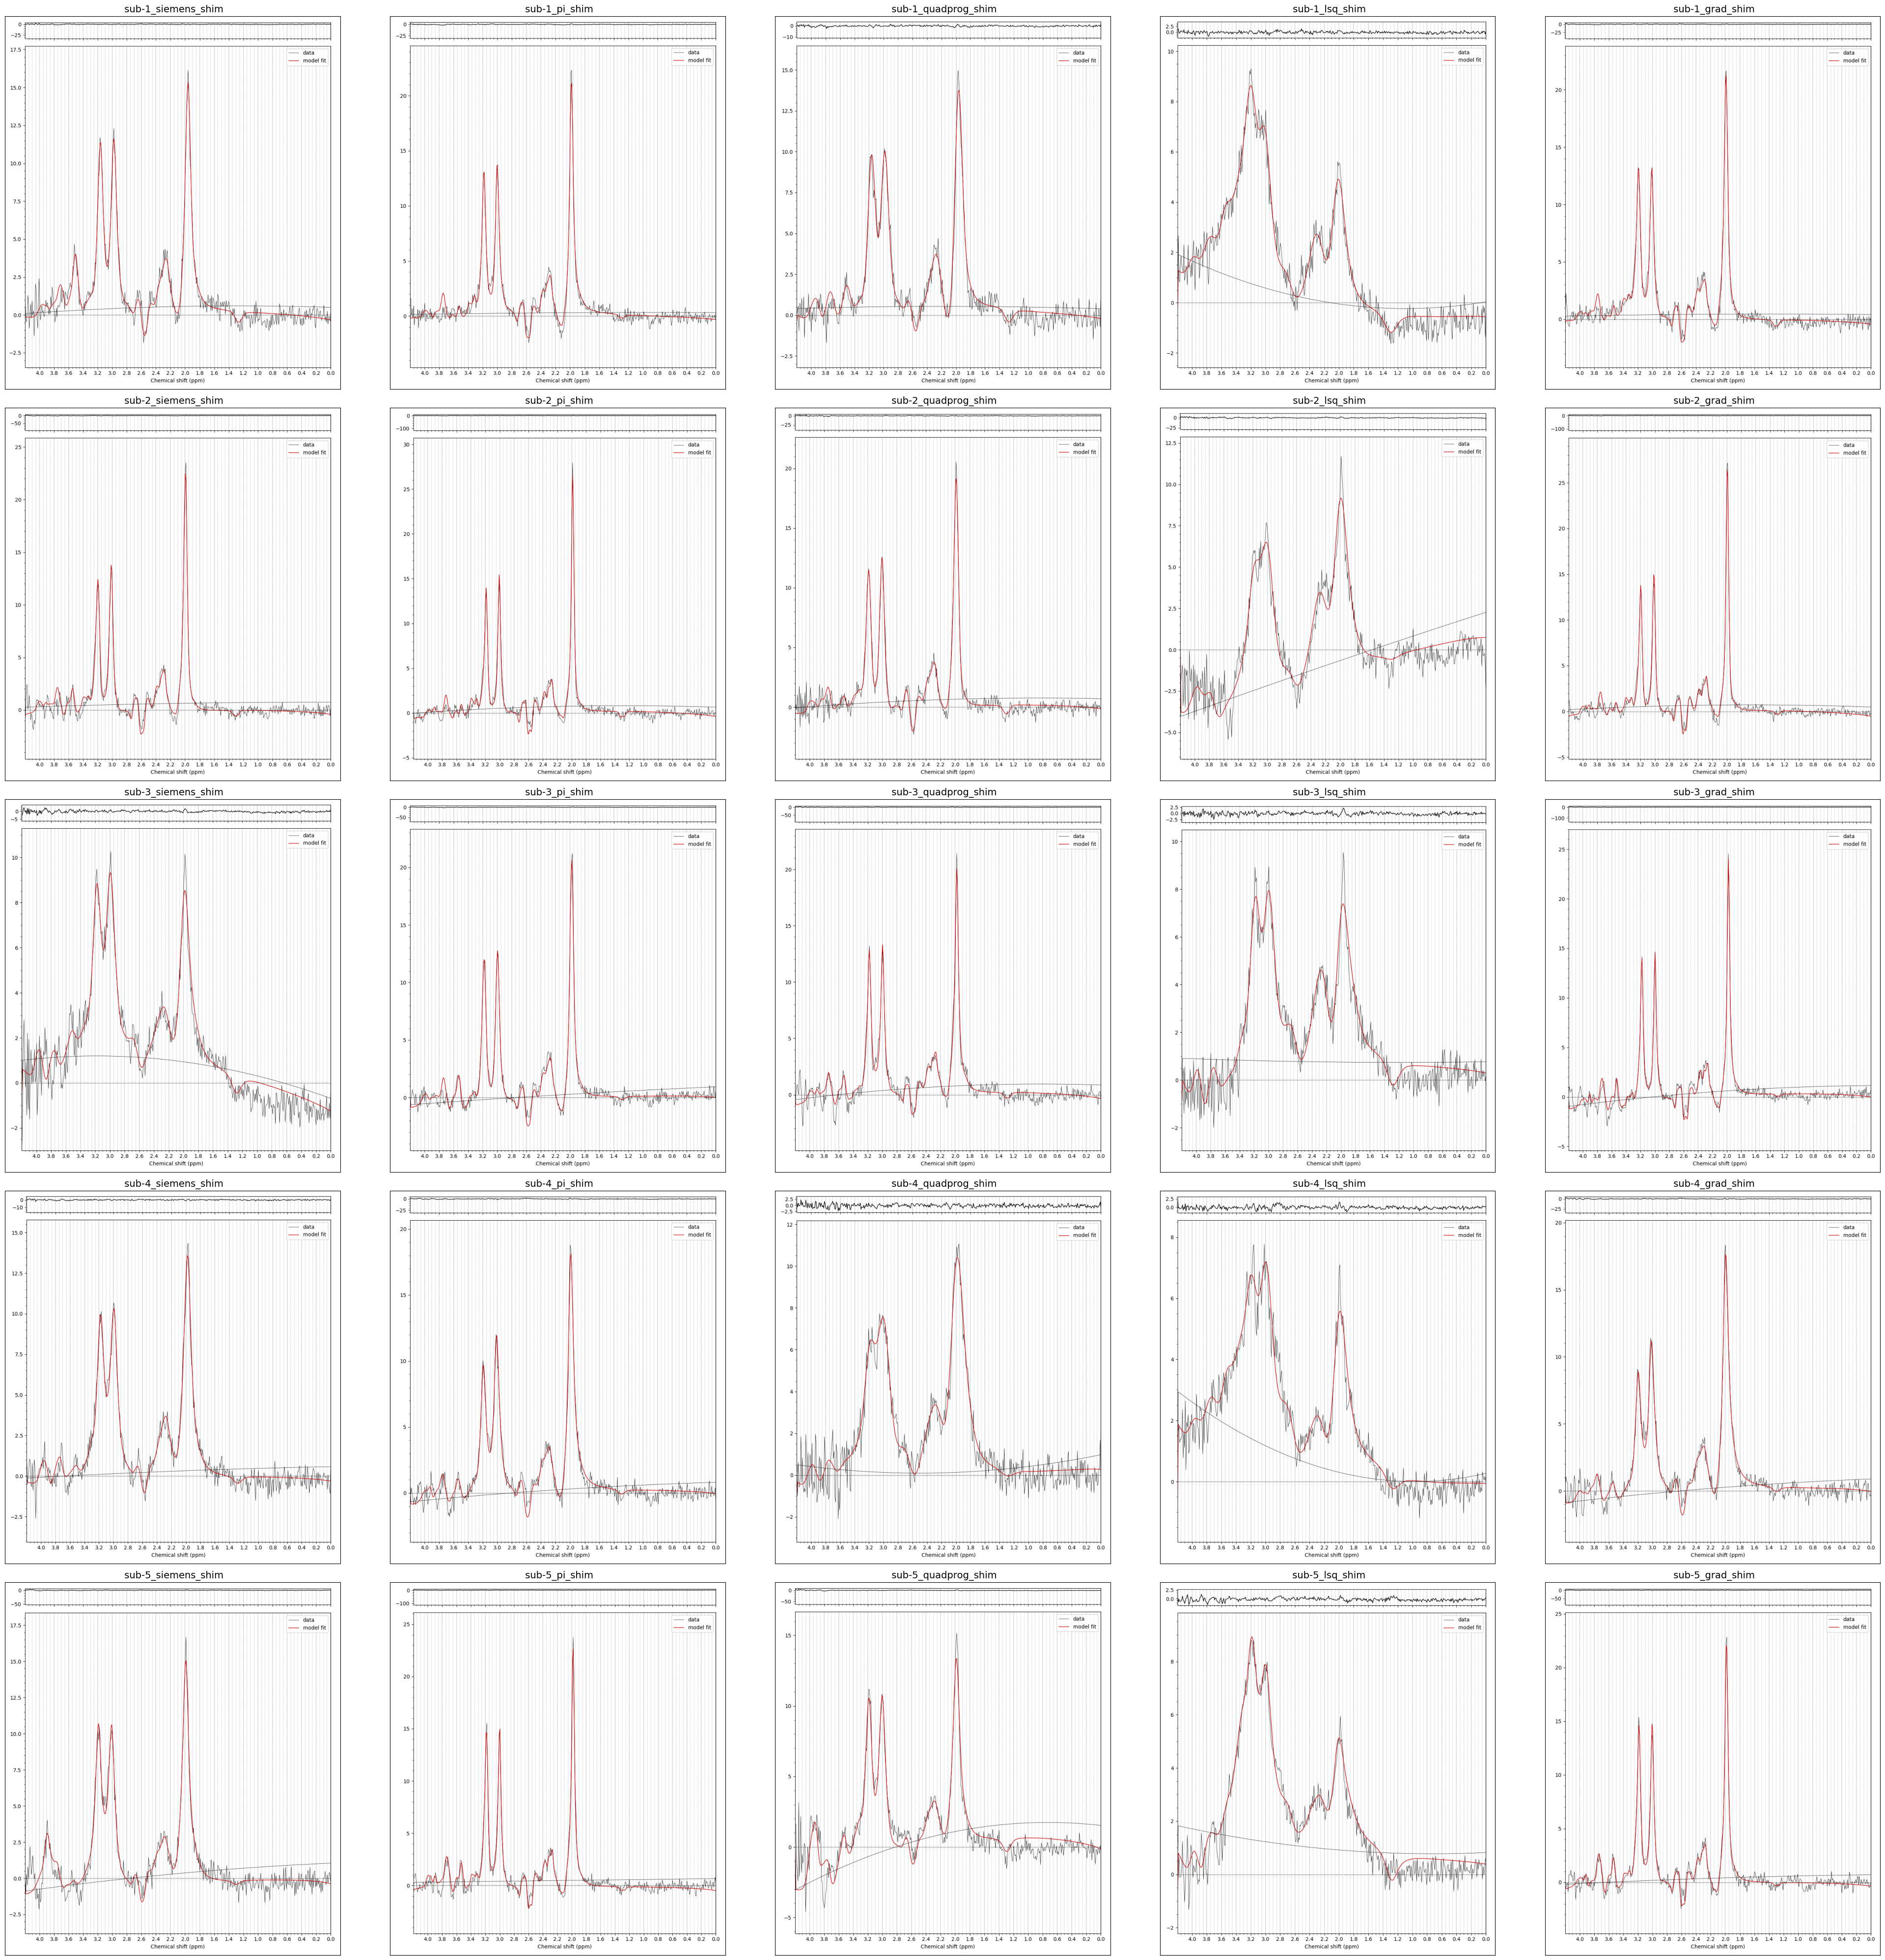

In [8]:
# Iterate over each subject
current_path = os.getcwd()
index = 1
plt.figure(figsize=(40, 40))
plt.subplots_adjust(wspace=0, hspace=0)
shim_methods=['siemens','pi' ,'quadprog' ,'lsq','grad']
for subject in subjects_list:
    for method in shim_methods:
        fit_path = current_path + f"/derivatives/{subject}/mrs/{method}_fit_result/"
        plt.subplot(len(subjects_list),len(shim_methods), index)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(plt.imread(fit_path + 'fit_summary.png'))
        plt.title(f" {subject}_{method}_shim", fontsize=14)
        index += 1

# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig(current_path + '/derivatives/All_subjects/mrs_fittings.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()


### 7.3. Extract the metabolites fit results from the CSV files

In [17]:
# Example path to the current directory
current_path = os.getcwd()

# Iterate over each subject and shim method to extract CRLB values
crlb_NAA_all = {}
crlb_CR_all = {}
crlb_CHO_all = {}
fwhm_NAA_all = {}
snr_NAA_all = {}
fwhm_CR_all = {}
snr_CR_all = {}
fwhm_CHO_all = {}
snr_CHO_all = {}
plt.figure(figsize=(20, 20))
index = 1
for subject in subjects_list:
    crlb_NAA_all[subject] = {}
    crlb_CR_all[subject] = {}
    crlb_CHO_all[subject] = {}
    fwhm_NAA_all[subject] = {}
    snr_NAA_all[subject] = {}
    fwhm_CR_all[subject] = {}
    snr_CR_all[subject] = {}
    fwhm_CHO_all[subject] = {}
    snr_CHO_all[subject] = {}
    for method in shim_methods:
        fit_path = os.path.join(current_path, f"derivatives/{subject}/mrs/{method}_fit_result/")

        # Read summary.csv file
        summary_file_path = os.path.join(fit_path, 'summary.csv')
        if os.path.exists(summary_file_path):
            df = pd.read_csv(summary_file_path)
            # if method == 'siemens':
            #     print(df)

            # Get the values for NAA, cr, cho
            CRLB_Cr = df.at[2, '%CRLB']
            crlb_CR_all[subject][method] = CRLB_Cr

            CRLB_CHO = df.at[15, '%CRLB']
            crlb_CHO_all[subject][method] = CRLB_CHO

            CRLB_NAA = df.at[13, '%CRLB']
            crlb_NAA_all[subject][method] = CRLB_NAA

            fwhm_NAA = df.at[13, 'FWHM']
            snr_NAA = df.at[13, 'SNR']
            fwhm_NAA_all[subject][method] = fwhm_NAA
            snr_NAA_all[subject][method] = snr_NAA

            fwhm_CR = df.at[2, 'FWHM']
            snr_CR = df.at[2, 'SNR']
            fwhm_CR_all[subject][method] = fwhm_CR
            snr_CR_all[subject][method] = snr_CR

            fwhm_CHO = df.at[15, 'FWHM']
            snr_CHO = df.at[15, 'SNR']
            fwhm_CHO_all[subject][method] = fwhm_CHO
            snr_CHO_all[subject][method] = snr_CHO



<Figure size 2000x2000 with 0 Axes>

### 7.4. Comparing metabolites' FWHM and SNR

<ipython-input-29-e975d5895f3e>:53: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-29-e975d5895f3e>:54: UserWarning:

FixedFormatter should only be used together with FixedLocator

<ipython-input-29-e975d5895f3e>:55: UserWarning:

FixedFormatter should only be used together with FixedLocator



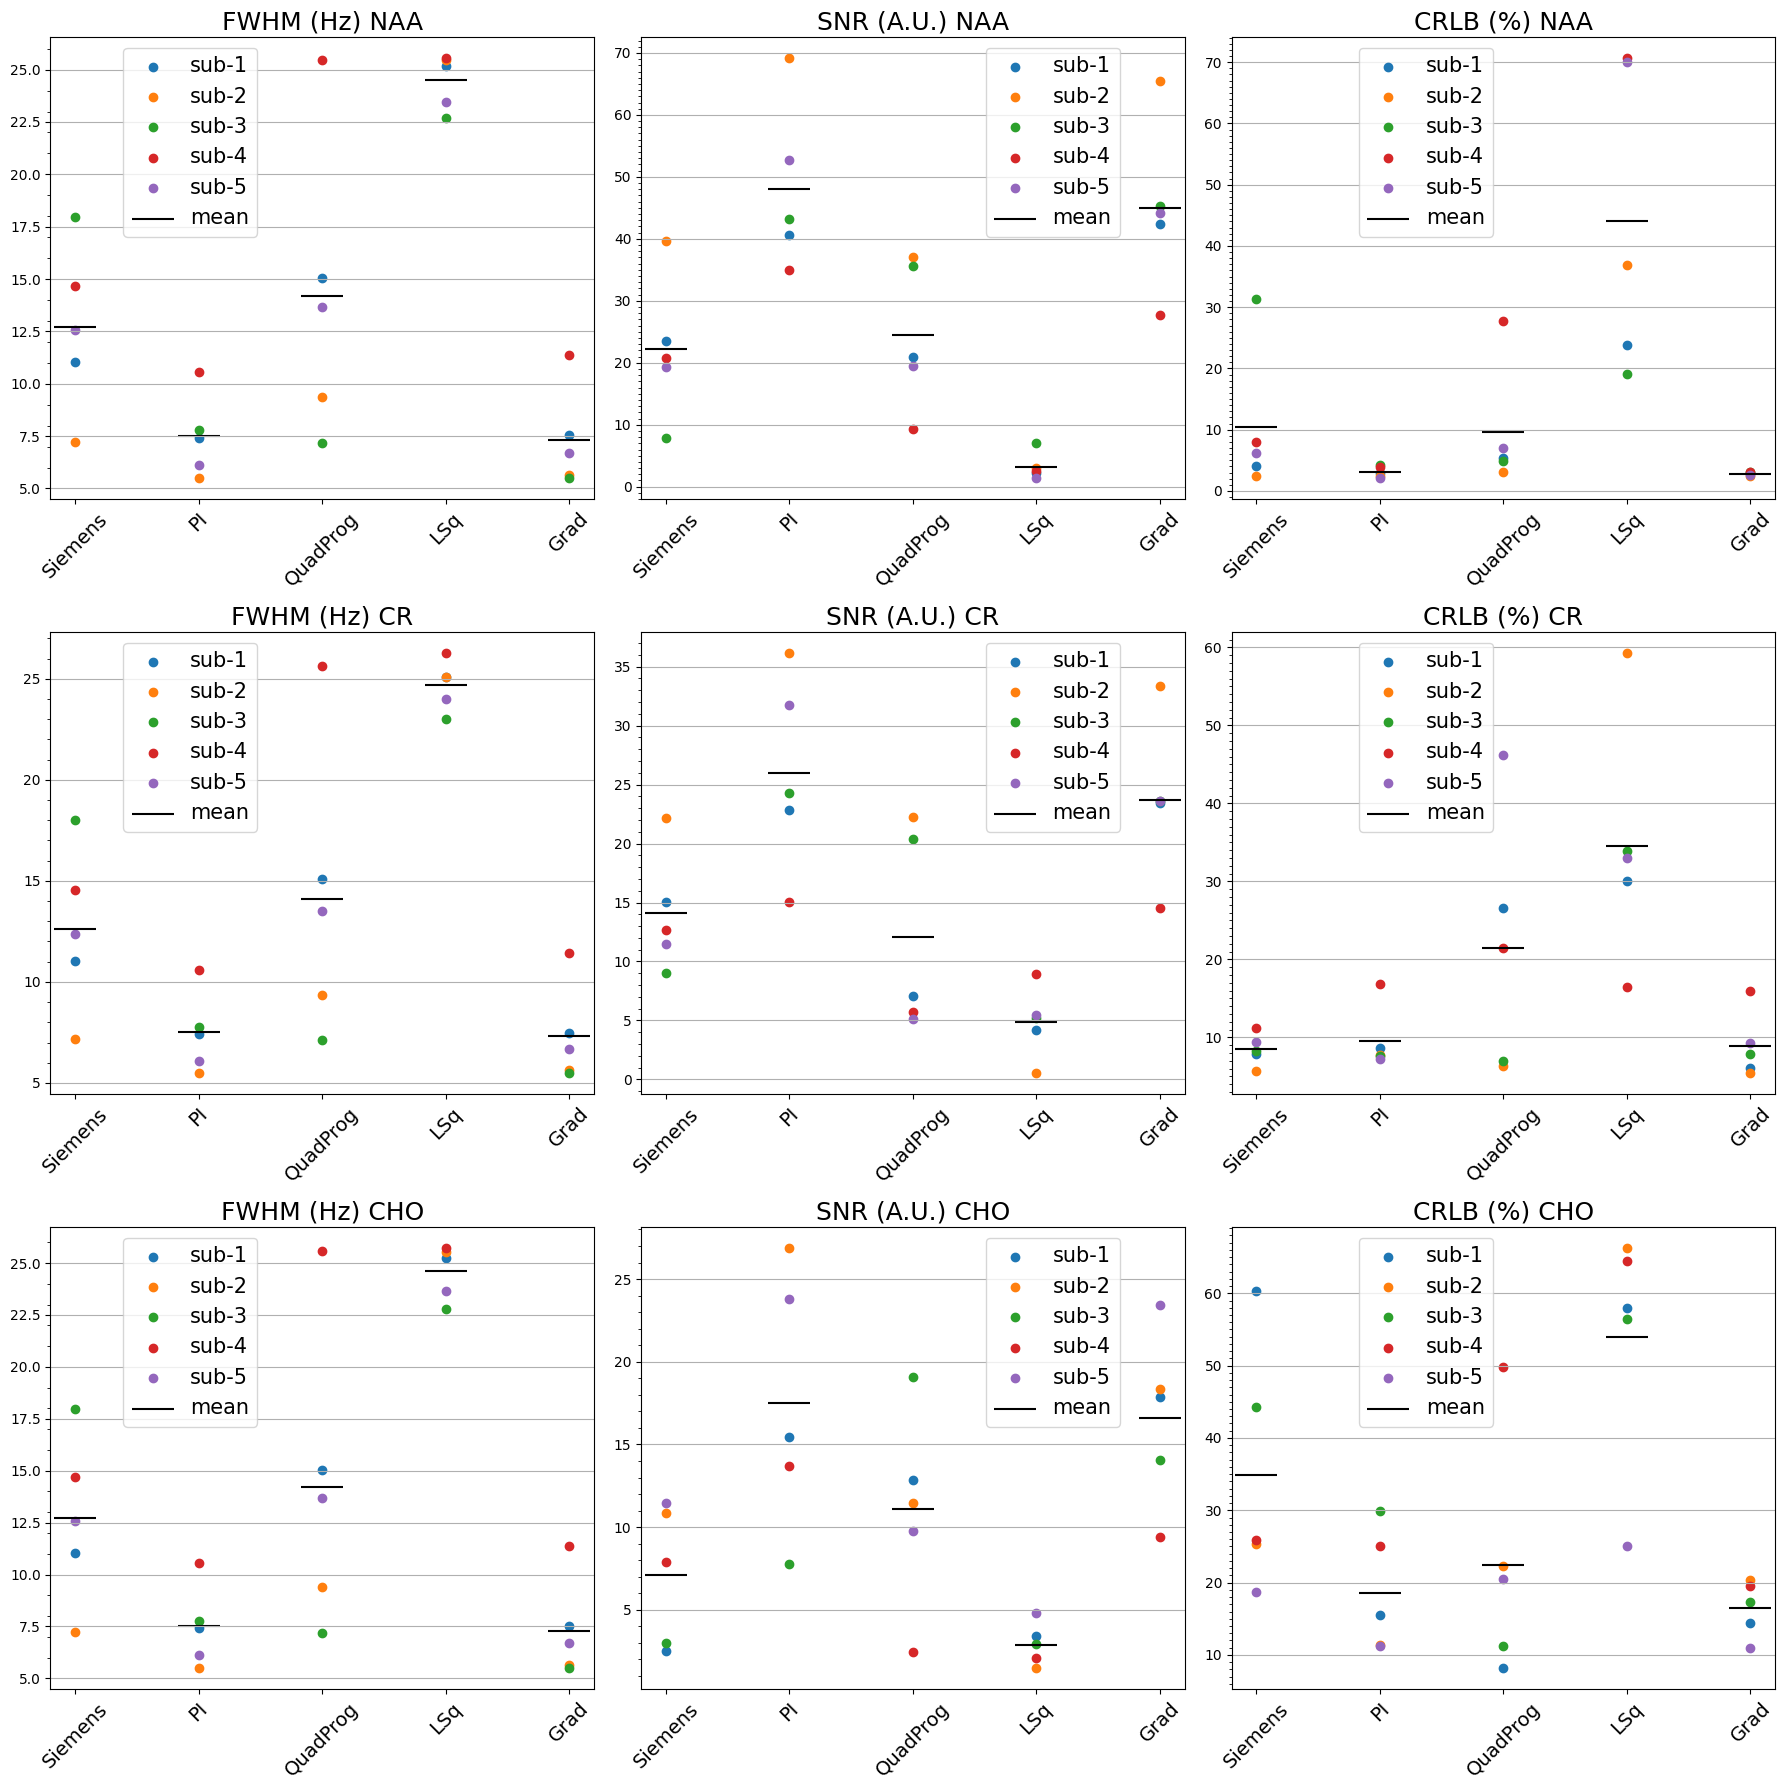

In [29]:
metab_list= ['NAA', 'CR', 'CHO']
# Create figure and axes
fig, axs = plt.subplots(len(metab_list), 3, figsize=(18, 18))
import matplotlib.markers as mmarkers

# Define a horizontal line marker
hline_marker = mmarkers.MarkerStyle('_')
hline_marker._transform = hline_marker.get_transform().scale(5, 5)
mean_fwhm_all = {}
mean_snr_all = {}
mean_crlb_all = {}
for i, metab in enumerate(metab_list):
    # Compute the mean values for FWHM and SNR for each metabolite
    mean_fwhm = {key: np.round(np.mean([globals()[f'fwhm_{metab}_all'][sub][key] for sub in globals()[f'fwhm_{metab}_all']]), decimals=1) for key in globals()[f'fwhm_{metab}_all']['sub-1'].keys()}
    mean_snr = {key: np.round(np.mean([globals()[f'snr_{metab}_all'][sub][key] for sub in globals()[f'snr_{metab}_all']]), decimals=1) for key in globals()[f'snr_{metab}_all']['sub-1'].keys()}
    mean_crlb = {key: np.round(np.mean([globals()[f'crlb_{metab}_all'][sub][key] for sub in globals()[f'crlb_{metab}_all']]), decimals=1) for key in globals()[f'crlb_{metab}_all']['sub-1'].keys()}
    mean_fwhm_all[metab] = mean_fwhm
    mean_snr_all[metab] = mean_snr
    mean_crlb_all[metab] = mean_crlb

    # Plot FWHM
    axs[i, 0].set_title(f"FWHM (Hz) {metab}", fontsize=18)
    for sub in globals()[f'fwhm_{metab}_all']:
        axs[i, 0].scatter(list(globals()[f'fwhm_{metab}_all'][sub].keys()), list(globals()[f'fwhm_{metab}_all'][sub].values()), label=sub)
    axs[i, 0].scatter(list(mean_fwhm.keys()), list(mean_fwhm.values()), color='black', marker=hline_marker, label='mean')
    axs[i, 0].legend(prop={'size': 15}, loc='upper right', bbox_to_anchor=(0.4, 1))
    axs[i, 0].tick_params(axis='x', rotation=45, labelsize=14)
    axs[i, 0].yaxis.set_minor_locator(plt.MultipleLocator(1))  # Set minor ticks for y-axis
    axs[i, 0].grid(which='major', axis='y')

    # Plot SNR
    axs[i, 1].set_title(f"SNR (A.U.) {metab}", fontsize=18)
    for sub in globals()[f'snr_{metab}_all']:
        axs[i, 1].scatter(list(globals()[f'snr_{metab}_all'][sub].keys()), list(globals()[f'snr_{metab}_all'][sub].values()), label=sub)
    axs[i, 1].scatter(list(mean_snr.keys()), list(mean_snr.values()), color='black', marker= hline_marker, label='mean')
    axs[i, 1].legend(prop={'size': 15}, loc='upper right', bbox_to_anchor=(0.9, 1))
    axs[i, 1].tick_params(axis='x', rotation=45, labelsize=14)
    axs[i, 1].yaxis.set_minor_locator(plt.MultipleLocator(1))  # Set minor ticks for y-axis
    axs[i, 1].grid(which='major', axis='y')


    # Plot crlb
    axs[i, 2].set_title(f"CRLB (%) {metab}", fontsize=18)
    for sub in globals()[f'crlb_{metab}_all']:
        axs[i, 2].scatter(list(globals()[f'crlb_{metab}_all'][sub].keys()), list(globals()[f'crlb_{metab}_all'][sub].values()), label=sub)
    axs[i, 2].scatter(list(mean_crlb.keys()), list(mean_crlb.values()), color='black', marker= hline_marker, label='mean')
    axs[i, 2].legend(prop={'size': 15}, loc='upper right', bbox_to_anchor=(0.5, 1))
    axs[i, 2].tick_params(axis='x', rotation=45, labelsize=14)
    axs[i, 2].yaxis.set_minor_locator(plt.MultipleLocator(1))  # Set minor ticks for y-axis
    axs[i, 2].grid(which='major', axis='y')

    # Set x tick labels
    axs[i, 0].set_xticklabels(["Siemens", "PI", "QuadProg", "LSq", "Grad"])
    axs[i, 1].set_xticklabels(["Siemens", "PI", "QuadProg", "LSq", "Grad"])
    axs[i, 2].set_xticklabels(["Siemens", "PI", "QuadProg", "LSq", "Grad"])

# Adjust layout
fig.tight_layout()
plt.savefig(current_path + '/derivatives/All_subjects/FWHM_SNR_comparison.png', dpi=300, bbox_inches='tight')
# Show the plot
plt.show()


### 7.5. Create a CSV output  

In [11]:
# Initialize lists for each criteria
all_data_dicts_fwhm = []
all_data_dicts_snr = []
all_data_dicts_crlb = []
current_path = os.getcwd()
criteria_list = ['fwhm', 'snr', 'crlb']

for criteria in criteria_list:
    mean_criteria_all = globals()[f'mean_{criteria}_all']

    # Calculate the percentage difference for each dictionary
    percentage_diff_dict = {}
    for metab, values in mean_criteria_all.items():
        siemens_value = values['siemens']
        percentage_diff = {}
        for key, value in values.items():
            if key != 'siemens':
                percentage_diff[key] = ((value - siemens_value) / siemens_value) * 100
        percentage_diff_dict[metab] = percentage_diff

    # Concatenate the original data and the percentage difference data
    for metab, values in mean_criteria_all.items():
        combined_dict = {'metabolite': metab}
        for key, value in values.items():
            combined_dict[f'{key}'] = round(value, 1)  # Round to one decimal place
            if key != 'siemens':
                combined_dict[f'{key} change (%)'] = round(percentage_diff_dict[metab].get(key, None), 1)  # Round to one decimal place
        if criteria == 'fwhm':
            all_data_dicts_fwhm.append(combined_dict)
        elif criteria == 'snr':
            all_data_dicts_snr.append(combined_dict)
        elif criteria == 'crlb':
            all_data_dicts_crlb.append(combined_dict)

# Create DataFrames for each criteria
df_fwhm = pd.DataFrame(all_data_dicts_fwhm)
df_snr = pd.DataFrame(all_data_dicts_snr)
df_crlb = pd.DataFrame(all_data_dicts_crlb)
# Display the DataFrames
df_fwhm_styled = df_fwhm.style.set_table_styles([{'selector': 'th', 'props': [('background', '#f7f7f9'), ('color', 'black'), ('border', '1px solid #dee2e6')]}])
df_fwhm_formatted = df_fwhm.apply(lambda x: x.apply(lambda y: '{:.1f}'.format(y) if isinstance(y, float) else y))

df_snr_styled = df_snr.style.set_table_styles([{'selector': 'th', 'props': [('background', '#f7f7f9'), ('color', 'black'), ('border', '1px solid #dee2e6')]}])
df_snr_formatted = df_snr.apply(lambda x: x.apply(lambda y: '{:.1f}'.format(y) if isinstance(y, float) else y))

df_crlb_styled = df_crlb.style.set_table_styles([{'selector': 'th', 'props': [('background', '#f7f7f9'), ('color', 'black'), ('border', '1px solid #dee2e6')]}])
df_crlb_formatted = df_crlb.apply(lambda x: x.apply(lambda y: '{:.1f}'.format(y) if isinstance(y, float) else y))

# Display the styled DataFrames
print("FWHM DataFrame:")
display(df_fwhm_formatted)

print("SNR DataFrame:")
display(df_snr_formatted)

print("CRLB DataFrame:")
display(df_crlb_formatted)

separator_row_snr = pd.DataFrame({'metabolite': ['SNR']})
separator_row_crlb = pd.DataFrame({'metabolite': ['CRLB']})
# Create a separator row with repeated column names
separator_row_columns = pd.DataFrame([df_fwhm_formatted.columns], columns=df_fwhm_formatted.columns)

# Concatenate the DataFrames with the separator rows
combined_df = pd.concat([ df_fwhm_formatted, separator_row_snr, separator_row_columns, df_snr_formatted, separator_row_crlb, separator_row_columns,df_crlb_formatted], axis=0)

# Save the combined DataFrame to a CSV file
combined_df.to_csv(current_path + '/derivatives/All_subjects/Metabolites_fit.csv', index=False)

FWHM DataFrame:


metabolite siemens   pi pi change (%) quadprog quadprog change (%)   lsq  \
0        NAA    12.5  7.2         -42.4     14.0                12.0  24.4   
1         CR    12.6  7.5         -40.5     14.1                11.9  24.7   
2        CHO    12.6  7.5         -40.5     14.1                11.9  24.6   

  lsq change (%) grad grad change (%)  
0           95.2  7.1           -43.2  
1           96.0  7.3           -42.1  
2           95.2  7.3           -42.1

SNR DataFrame:


metabolite siemens    pi pi change (%) quadprog quadprog change (%)  lsq  \
0        NAA     1.8   0.6         -66.7      1.5               -16.7  5.4   
1         CR    14.1  26.0          84.4     12.1               -14.2  4.9   
2        CHO     1.6   2.9          81.2      4.7               193.8  3.4   

  lsq change (%)  grad grad change (%)  
0          200.0   0.6           -66.7  
1          -65.2  23.7            68.1  
2          112.5   2.9            81.2

CRLB DataFrame:


metabolite siemens    pi pi change (%) quadprog quadprog change (%)   lsq  \
0        NAA    66.4  89.5          34.8     76.2                14.8  22.2   
1         CR     8.5   9.6          12.9     21.5               152.9  34.5   
2        CHO    72.9  66.2          -9.2     53.1               -27.2  40.1   

  lsq change (%)  grad grad change (%)  
0          -66.6  82.4            24.1  
1          305.9   8.9             4.7  
2          -45.0  60.5           -17.0